# Day 5 - Credit Card Fraud Detection - Handling Imbalanced Data
## Ernesto Gonzales, MSDA

### Introduction 
This project uses the **Kaggle Credit Card Fraud Detection Dataset**.

It contains ~285,000 transactions, of which only ~0.17% are labeled as fraud.

### Why imbalance matters:
- Most transactions are legitimate.
- A naive model that predicts "non-fraud" every time would reach ~99% accuracy but be useless.
- In security and fraud, its instrumental to **catch the rare class than raw accuracy**.

### Business + Security Relevance:
Fraudulent transactions in finance are similar to rare cyberattacks in security logs.
Detecting these rare events is critical, despite an increase in more false alarms.

### Exploratory Data Analysis

In [1]:
# Importing libraries
import pandas as pd
import numpy as np

In [2]:
# Loading dataset

df = pd.read_csv("../data/creditcard.csv")

In [3]:
# Data preview, shape, and missing values

print(f"Dataset shape: {df.shape[0]} rows, {df.shape[1]} columns")

df.head()
total_missing = df.sum().isna().sum()
print(f"\n Total missing values in dataset: {total_missing}")

Dataset shape: 284807 rows, 31 columns

 Total missing values in dataset: 0


In [4]:
# Class Imbalance
# Froud cases are Class = 1, and they are very rare in contrast with non-froud (Class = 0).

class_counts = df['Class'].value_counts().sort_index()
class_ratios = class_counts / class_counts.sum()

print("\n Class Distribuion:")
print(class_counts)
print("\n Class ratios:")
print(class_ratios)


 Class Distribuion:
Class
0    284315
1       492
Name: count, dtype: int64

 Class ratios:
Class
0    0.998273
1    0.001727
Name: count, dtype: float64


In [5]:
# Data types preview

print("\nData Type summary:")
print(df.dtypes.value_counts())


Data Type summary:
float64    30
int64       1
Name: count, dtype: int64


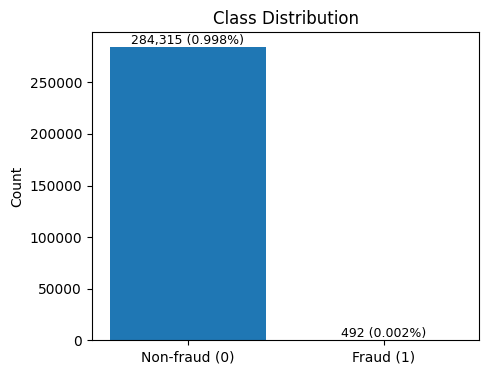

In [46]:
# Bar Chart

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(5,4))
bars = ax.bar(["Non-fraud (0)", "Fraud (1)"], class_counts.values)
ax.set_title("Class Distribution")
ax.set_ylabel("Count")

for bar, perc in zip(bars,class_ratios.values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f"{int(height):,} ({perc:.3f}%)",
    ha="center", va="bottom", fontsize=9)
fig.savefig("../docs/cc_imbalanced_day_05_class_dist.png", dpi=150, bbox_inches="tight")
plt.show()

### Creating Baseline Models

In [11]:
# Importing libraries

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Train/test split
from sklearn.model_selection import train_test_split

# Model metrics

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay)


In [12]:
# Separating features
X = df.drop("Class", axis=1)
y = df["Class"]

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [13]:
# Initial models

log_reg = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)
rand_forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# Training models
log_reg.fit(X_train, y_train)
rand_forest.fit(X_train, y_train)

# Predictions

y_pred_log = log_reg.predict(X_test)
y_pred_rf = rand_forest.predict(X_test)




In [14]:
# Evaluating metrics using a function

def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_pred)
    print(f"\n{model_name} results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precission: {prec:.4f}")
    print(f"Recall: {rec: .4f}")
    print(f"F1 Score: {f1: .4f}")
    print(f"ROC AUC: {roc: .4f}")

# Comparing baseline models

evaluate_model(y_test, y_pred_log, "Logistic Regression (baseline)")
evaluate_model(y_test, y_pred_rf, "Random Forest (baseline)")
    


Logistic Regression (baseline) results:
Accuracy: 0.9992
Precission: 0.8481
Recall:  0.6837
F1 Score:  0.7571
ROC AUC:  0.8417

Random Forest (baseline) results:
Accuracy: 0.9996
Precission: 0.9412
Recall:  0.8163
F1 Score:  0.8743
ROC AUC:  0.9081


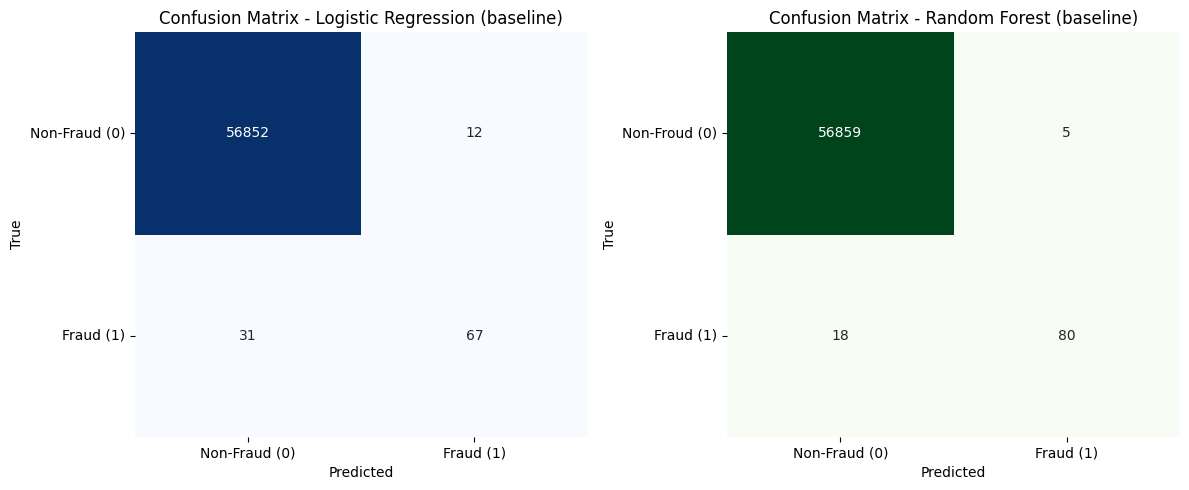

In [45]:
# Visualizations
# Confusion Matrices + ROC + Precission-Recall

cm_log = confusion_matrix(y_test, y_pred_log, labels=[0,1])
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=[0,1])

fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title("Confusion Matrix - Logistic Regression (baseline)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")
axes[0].set_xticklabels(["Non-Fraud (0)", "Fraud (1)"])
axes[0].set_yticklabels(["Non-Fraud (0)", "Fraud (1)"], rotation=0)

sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens", cbar=False, ax=axes[1])
axes[1].set_title("Confusion Matrix - Random Forest (baseline)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")
axes[1].set_xticklabels(["Non-Fraud (0)", "Fraud (1)"])
axes[1].set_yticklabels(["Non-Froud (0)", "Fraud (1)"], rotation=0)

plt.tight_layout()
fig.savefig("../docs/cc_imbalanced_day_05_cf.png", dpi=150, bbox_inches="tight")
plt.show()

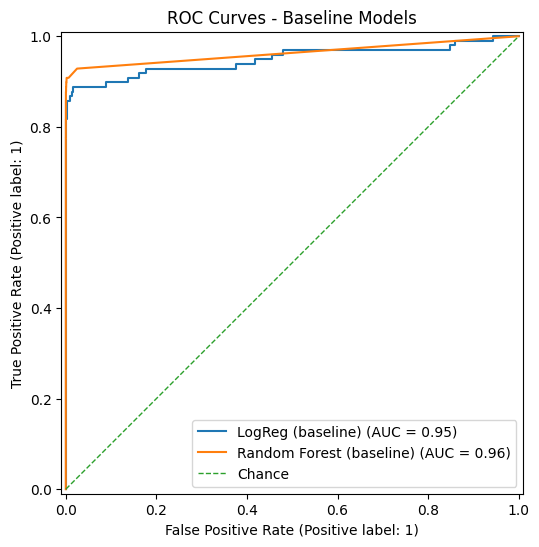

In [44]:
# ROC Curves

y_score_log = log_reg.predict_proba(X_test)[:,1]
y_score_rf = rand_forest.predict_proba(X_test)[:,1]

fig, ax = plt.subplots(figsize=(7,6))
RocCurveDisplay.from_predictions(y_test, y_score_log, name="LogReg (baseline)", ax=ax)
RocCurveDisplay.from_predictions(y_test, y_score_rf, name="Random Forest (baseline)", ax=ax)
ax.plot([0,1],[0,1], linestyle="--", linewidth=1, label="Chance")
ax.set_title("ROC Curves - Baseline Models")
ax.legend(loc="lower right")
fig.savefig("../docs/cc_imbalanced_day_05_roc_baselines.png", dpi=150, bbox_inches="tight")
plt.show()

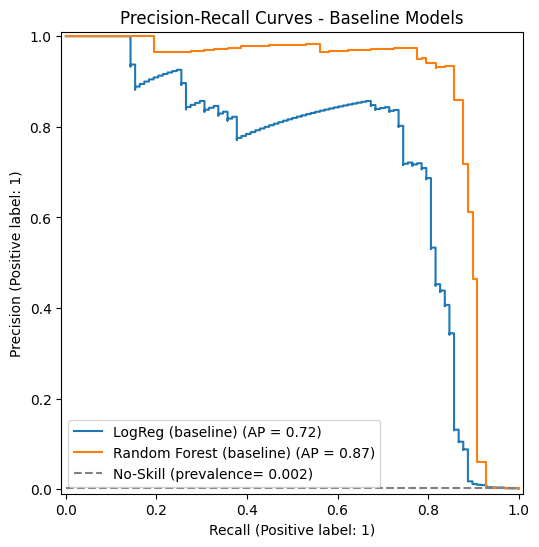

In [47]:
# Precision-recall curves

fig, ax = plt.subplots(figsize=(7,6))
PrecisionRecallDisplay.from_predictions(y_test, y_score_log, name="LogReg (baseline)", ax=ax)
PrecisionRecallDisplay.from_predictions(y_test, y_score_rf, name="Random Forest (baseline)", ax=ax)

pos_rate = y_test.mean()
ax.hlines(pos_rate, xmin=0, xmax=1, colors="gray", linestyles="--", label=f"No-Skill (prevalence={pos_rate: .3f})")
ax.set_title("Precision-Recall Curves - Baseline Models")
ax.legend(loc="lower left")
fig.savefig("../docs/cc_imbalanced_day_05_PR_curves_baselines.png", dpi=150, bbox_inches="tight")
plt.show()

### Balancing Techniques: Random UnderSampling & SMOTE


In [18]:
!pip install imbalanced-learn

In [19]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


In [21]:
# Samplers set-up

undersample = RandomUnderSampler(random_state=42)
smote = SMOTE(random_state=42)

In [22]:
# Apply undersampling

X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
print("After undersampling:", np.bincount(y_train_under))

After undersampling: [394 394]


In [23]:
# Apply SMOTE oversampling

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("After SMOTE: ", np.bincount(y_train_smote))


After SMOTE:  [227451 227451]


In [24]:
# Retraining models with undersampling

log_reg_under = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)
rand_forest_under = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

log_reg_under.fit(X_train_under, y_train_under)
rand_forest_under.fit(X_train_under, y_train_under)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
# Retraining models with SMOTE

log_reg_smote = LogisticRegression(max_iter=1000, n_jobs=-1,  random_state=42)
rand_forest_smote = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

log_reg_smote.fit(X_train_smote, y_train_smote)
rand_forest_smote.fit(X_train_smote, y_train_smote)



,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [26]:
# Model evaluation and comparison with Test set

def eval_and_plot(y_true, model, X_test, name):
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:,1]
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"{name:30s} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
    return y_score


In [27]:
print("\n--- UnderSampling Results ---")
score_log_under = eval_and_plot(y_test, log_reg_under, X_test, "LogReg (undersample)")
score_rf_under = eval_and_plot(y_test, rand_forest_under, X_test, "RandomForest (undersample)")

print("\n--- SMOTE Results ---")
score_log_smote = eval_and_plot(y_test, log_reg_smote, X_test, "LogReg (SMOTE)")
score_rf_smote = eval_and_plot(y_test, rand_forest_smote, X_test, "RandomForest (SMOTE)")


--- UnderSampling Results ---
LogReg (undersample)           | Precision: 0.033 | Recall: 0.918 | F1: 0.064
RandomForest (undersample)     | Precision: 0.042 | Recall: 0.918 | F1: 0.081

--- SMOTE Results ---
LogReg (SMOTE)                 | Precision: 0.126 | Recall: 0.908 | F1: 0.221
RandomForest (SMOTE)           | Precision: 0.827 | Recall: 0.827 | F1: 0.827


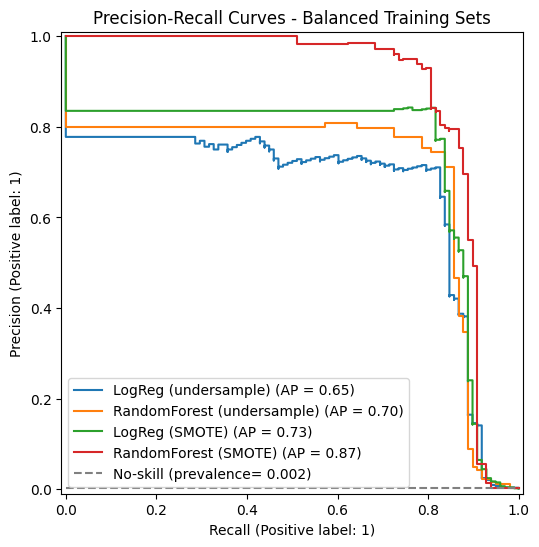

In [48]:
# Plotting Precision-recall curves for comparison

fig, ax = plt.subplots(figsize=(7,6))
PrecisionRecallDisplay.from_predictions(y_test, score_log_under, name="LogReg (undersample)", ax=ax)
PrecisionRecallDisplay.from_predictions(y_test, score_rf_under, name="RandomForest (undersample)", ax=ax)
PrecisionRecallDisplay.from_predictions(y_test, score_log_smote, name="LogReg (SMOTE)", ax=ax)
PrecisionRecallDisplay.from_predictions(y_test, score_rf_smote, name="RandomForest (SMOTE)", ax=ax)
ax.hlines(pos_rate, xmin=0, xmax=1, colors="gray", linestyles="--", label=f"No-skill (prevalence={pos_rate: .3f})")
ax.set_title("Precision-Recall Curves - Balanced Training Sets")
ax.legend(loc="lower left")
fig.savefig("../docs/cc_imbalanced_day_05_PR_balanced.png", dpi=150, bbox_inches="tight")
plt.show()

### Pipeline + Class Weights (Leak-safe training)
### Goal:
- Placing SMOTE inside a pipeline so resampling only happens on training folds.
- Add scaling for LR (Amount, Time aren't PCA'd).
- Use class_weight='balanced' so the model pays more attention to minority class.


In [29]:
# Logistic regresion Pipeline

from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe_lr = Pipeline(steps=[
                   ("scaler", StandardScaler()), # Scaling Numeric features (LR benefits)
                   ("smote", smote), # resampling after scaling, before model
                    ("model", LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1, random_state=42))])


In [30]:
# Random forest Pipeline

pipe_rf = Pipeline(steps=[
    ("smote", smote),
    ("model", RandomForestClassifier(n_estimators=300, class_weight="balanced_subsample", n_jobs=-1, random_state=42))])

In [31]:
# Fitting models in the original imbalanced train set

pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

# Getting probabilities for evaluation & threshold tuning

proba_lr = pipe_lr.predict_proba(X_test)[:,1]
proba_rf = pipe_rf.predict_proba(X_test)[:,1]


In [32]:
# Creating a function to evaluate models

from sklearn.metrics import average_precision_score

def evaluate_at_threshold(y_true, y_score, threshold, label):
    y_pred = (y_score >= threshold).astype(int)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    ap = average_precision_score(y_true, y_pred) # Area under PR curve
    print(f"{label:28s} @ thr={threshold:0.3f} | Precision: {prec:0.3f} | Recall: {rec:0.3f} | F1: {f1:0.3f} | AP (PR-AUC): {ap:0.3f}")


In [33]:
# Showing metrics using function

evaluate_at_threshold(y_test, proba_lr, 0.50, "LR (SMOTE+balanced)")
evaluate_at_threshold(y_test, proba_lr, 0.20, "LR (SMOTE+balanced)")

evaluate_at_threshold(y_test, proba_rf, 0.50, "RD (SMOTE+balanced)")
evaluate_at_threshold(y_test, proba_rf, 0.20, "RD (SMOTE+balanced)")

LR (SMOTE+balanced)          @ thr=0.500 | Precision: 0.058 | Recall: 0.918 | F1: 0.109 | AP (PR-AUC): 0.053
LR (SMOTE+balanced)          @ thr=0.200 | Precision: 0.016 | Recall: 0.918 | F1: 0.032 | AP (PR-AUC): 0.015
RD (SMOTE+balanced)          @ thr=0.500 | Precision: 0.830 | Recall: 0.847 | F1: 0.838 | AP (PR-AUC): 0.703
RD (SMOTE+balanced)          @ thr=0.200 | Precision: 0.544 | Recall: 0.888 | F1: 0.674 | AP (PR-AUC): 0.483


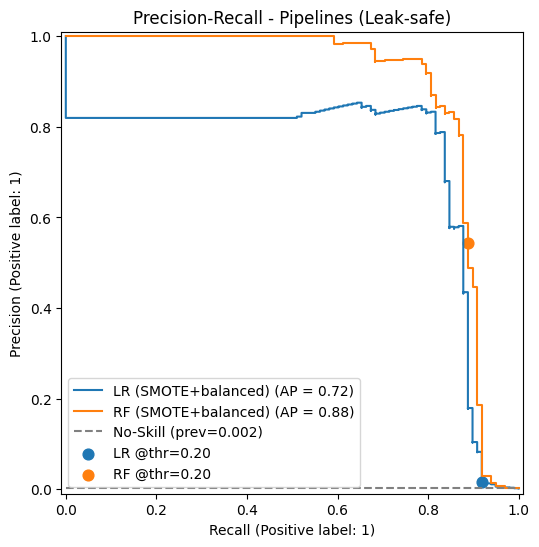

In [49]:
# Ploting PR Curves + threshold markers

fig, ax = plt.subplots(figsize=(7,6))
disp_lr = PrecisionRecallDisplay.from_predictions(y_test, proba_lr, name="LR (SMOTE+balanced)", ax=ax)
disp_rf = PrecisionRecallDisplay.from_predictions(y_test, proba_rf, name="RF (SMOTE+balanced)", ax=ax)

# Plotting the no-skill line

ax.hlines(pos_rate, xmin=0,xmax=1, colors="gray", linestyles="--", label=f"No-Skill (prev={pos_rate:.3f})")
ax.set_title("Precision-Recall - Pipelines (Leak-safe)")

# Adding mark threshold = 0.20 for both models

for score, name in [(proba_lr, "LR"), (proba_rf,"RF")]:
    thr = 0.20
    y_pred_thr = (score >= thr).astype(int)
    p = precision_score(y_test, y_pred_thr, zero_division=0)
    r = recall_score(y_test, y_pred_thr)
    ax.scatter(r,p, s=60, label=f"{name} @thr=0.20")

ax.legend(loc="lower left")
fig.savefig("../docs/cc_imbalanced_day_05_PR_pipelines.png", dpi=150, bbox_inches="tight")
plt.show()

### Threshold Scanning: Precision vs Recall Trade-offs

In [38]:
# Creating function

def scan_thresholds(y_true, y_proba, steps=21):
    # Returs a DF with precision/recalll/F1 across thresholds

    ths = np.linspace(0.05, 0.95, steps)
    rows = []
    for t in ths:
        y_pred = (y_proba >= t).astype(int)
        rows.append({
        "threshold": round(t, 2),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0)})
    return pd.DataFrame(rows)

# Logistic Regression with class_weight='balanced'
thr_df = scan_thresholds(y_test, proba_lr, steps=19)
display(thr_df.sort_values("f1", ascending=False).head(10))

best_row = thr_df.loc[thr_df["f1"].idxmax()]
print(f"Best threshold by F1: {best_row.threshold}, "
      f"Precision={best_row.precision:.3f}, Recall={best_row.recall:.3f}")

,threshold,precision,recall,f1
18,0.95,0.268519,0.887755,0.412322
17,0.90,0.191630,0.887755,0.315217
16,0.85,0.166667,0.897959,0.281150
15,0.80,0.139241,0.897959,0.241096
14,0.75,0.121715,0.897959,0.214373
13,0.70,0.104265,0.897959,0.186837
12,0.65,0.088294,0.908163,0.160940
11,0.60,0.077922,0.918367,0.143655
10,0.55,0.066617,0.918367,0.124224
9,0.50,0.057803,0.918367,0.108761


Best threshold by F1: 0.95, Precision=0.269, Recall=0.888
